In [1]:
from new_attempt.stateless import *

In [2]:
import numpy as np

In [3]:
import inspect

In [4]:
from matplotlib import pyplot as plt

In [5]:
preliminaryData = createPreliminaryData(3)

In [6]:
regionFunctions = generateRegionFunctions(preliminaryData)

In [7]:
def matchesToIdentifiers(expression, pattern): 
    matches = list(expression.find(pattern))
    return {match : symbolicToIdentifier(match) for match in matches}


In [8]:
def lambdifyWaveFunction(amplitudeCoefficientEquations : dict, position : sp.Symbol) -> dict: 
    unconstrainedParticularSolution = amplitudeCoefficientEquations["unconstrainedParticularSolution"]
    harmonicConstant = unconstrainedParticularSolution["amplitudes"]["harmonicConstant"]
    amplitudeCoefficients = list(amplitudeCoefficientEquations["extrapolatedComponentsOfConstants"].keys())
    exponential = unconstrainedParticularSolution["expandedExponential"]
    waveFunction = unconstrainedParticularSolution["exponential"].rhs
    functionSymbol = unconstrainedParticularSolution["exponential"].lhs.func
    conjugatedAmplitudeConstants = matchesToIdentifiers(
            exponential, 
            sp.conjugate(sp.Wild("C"))
        )
    sanitizedFunction = substituteIdentifierAtoms(
            exponential.subs(conjugatedAmplitudeConstants)
        )
    
    
    waveFunctionParameters = amplitudeCoefficients + [
          symbolicToIdentifier(parameter) \
          for parameter in [harmonicConstant, position]
        ]
    parameters = orderNames(
            list(conjugatedAmplitudeConstants.values()) \
                    + waveFunctionParameters
        )
    positionIdentifier = symbolicToIdentifier(position)
    amplitudeCoefficientSubstitutionList = substituteIdentifierAtomsList(exponential)
    conjugateMap = {}
    for conjugateSymbolic, identifier in conjugatedAmplitudeConstants.items():
        cleanSymbol = conjugateSymbolic.args[0]
        conjugateMap[amplitudeCoefficientSubstitutionList[cleanSymbol]] = identifier
        
    functionIdentifier = symbolicToIdentifier(functionSymbol)
    baseNumericalFunction =  sp.lambdify(parameters, sanitizedFunction)
    harmonicConstantIdentifier = symbolicToIdentifier(harmonicConstant)
    def makeFunctionFromConstants(constants : dict) -> float: 
        amplitudeCoefficeintSolutions_ = {
                solutionSetName : solutions \
                for solutionSetName, solutions \
                        in constants["amplitudeConstants"].items() \
                if solutionSetName in amplitudeCoefficients
            }
        arguments = {}
        for solutionSetName, solutions in amplitudeCoefficeintSolutions_.items(): 
            if len(solutions) == 2: 
                arguments[solutionSetName] = solutions[0] * 1j
                ############################################################
                ############################################################
                #######################!!!!  TESTING !!!!###################
                ############################################################
                ############################################################
                arguments[conjugateMap[solutionSetName]] = solutions[0] * -1j
            else: 
                if type(solutions) is list: 
                    assert len(solutions) == 1, "makeExponentialWithConjugates: " \
                                                "inproper number of solutions (must be zero or one)" \
                                                "for amplitude coefficient!"
                    arguments[solutionSetName] = solutions[0]
                else: 
                    arguments[solutionSetName] = solutions
        arguments[harmonicConstantIdentifier] = constants["harmonicConstants"] \
                [harmonicConstantIdentifier]
        return lambda position_ : baseNumericalFunction(**(
                {positionIdentifier : position_} 
                | arguments
            ))
    numericalWaveFunction = sp.lambdify(
            waveFunctionParameters, 
            substituteIdentifierAtoms(waveFunction)
        )
    def makeWaveFunctionFromConstants(constants : dict) -> complex: 
        arguments = {}
        for constant in amplitudeCoefficients: 
            solutions = constants["amplitudeConstants"][constant]
            if type(solutions) is list: 
                if len(solutions) == 2:
                    arguments[constant] = solutions[0] * 1j
                else: 
                    assert len(solutions) == 1, "makeWaveFunctionFromConstants: " \
                                            "inproper number of solutions (must be zero or one)" \
                                            "for amplitude coefficient!"
                    arguments[constant] = solutions[0] * 1j
            else: 
                    arguments[constant] = solutions
        arguments[harmonicConstantIdentifier] \
                = constants["harmonicConstants"][harmonicConstantIdentifier]
        return lambda position_ : numericalWaveFunction(
                **({positionIdentifier : position_} | arguments)
            )
    return {
            "name" : functionIdentifier, 
            "functionFromConstantsBuilder" : makeFunctionFromConstants, 
            "makeWaveFunction" : makeWaveFunctionFromConstants, 
            "parameters" : parameters, 
            "symbol" : functionSymbol, 
            "position" : position, 
            "harmonicConstant" : harmonicConstant, 
            "amplitudeCoefficientIdentifiers" : orderNames(amplitudeCoefficients), 
            "amplitudeConjugateCoefficientIdentifiers" : orderNames(list(
                    conjugatedAmplitudeConstants.values())
                ), 
        }

In [9]:
k_3 = 3

In [10]:
testBasicParameters = {
    "V_0" : 1, 
    "V_1" : 2, 
    "V_2" : 3, 
    "L_0" : 2, 
    "L_1" : 3, 
    "L_2" : 4, 
    "N_0" : .1, 
    "N_1" : .2, 
    "N_2" : .7, 
    "m" : 1, 
    "E_OCBtotalCCB" : .5, 
    "E_total" : .5, 
    "hbarX" : 1, 
    "k_3" : k_3, ###### FOR TESTING ONLY
    "L_N1" : 1, 
    "B_3" : 0
}

In [11]:
# Yoinked from computeSimulationConstants
harmonicConstants = {
        symbolicToIdentifier(functionData["equation"].lhs) 
                : computeHarmonicConstant(
                        functionData, 
                        testBasicParameters
                    ) \
        for functionData in regionFunctions["harmonicConstantFunctions"]
    }


In [12]:
harmonicConstants

{'k_0': 1.0000000000000002, 'k_1': 1.7320508075688772, 'k_2': 2.23606797749979}

In [13]:
harmonicConstants["k_3"] = k_3

In [14]:
harmonicConstants

{'k_0': 1.0000000000000002,
 'k_1': 1.7320508075688772,
 'k_2': 2.23606797749979,
 'k_3': 3}

In [15]:
trValues = {}
for trFunctions in regionFunctions["transmissionReflectionFunctions"]: 
    arguments = {parameter : harmonicConstants[parameter] for parameter in trFunctions["inputs"]}
    for name, calculator in trFunctions["computations"].items(): 
        trValues[name] = calculator(**arguments)

In [16]:
constants = computeSimulationConstants(preliminaryData, regionFunctions, testBasicParameters, 1, 1)

In [17]:
constants

{'harmonicConstants': {'k_0': 1.0000000000000002,
  'k_1': 1.7320508075688772,
  'k_2': 2.23606797749979},
 'transfers': [{'from': {'region': <new_attempt.stateless.RegionSymbols at 0x7f6f81a07e50>,
    'matrix': Matrix([
    [psi_2_t(L_1)],
    [psi_2_r(L_1)]])},
   'to': {'region': <new_attempt.stateless.RegionSymbols at 0x7f6f81a07a00>,
    'matrix': Matrix([
    [psi_3_t(L_2)],
    [psi_3_r(L_2)]])},
   'transferValues': {'psi_3_tOPL_2CP': 1, 'psi_3_rOPL_2CP': 1}},
  {'from': {'region': <new_attempt.stateless.RegionSymbols at 0x7f6f81a07e50>,
    'matrix': Matrix([
    [psi_2_t(L_1)],
    [psi_2_r(L_1)]])},
   'to': {'region': <new_attempt.stateless.RegionSymbols at 0x7f6f81a07a00>,
    'matrix': Matrix([
    [psi_3_t(L_2)],
    [psi_3_r(L_2)]])},
   'transferValues': {'psi_2_tOPL_1CP': 1.2909944487358058,
    'psi_2_rOPL_1CP': 0.5773502691896257}},
  {'from': {'region': <new_attempt.stateless.RegionSymbols at 0x7f6f81a07a00>,
    'matrix': Matrix([
    [psi_1_t(L_0)],
    [psi_1_r

In [18]:
waveFunctionGenerators = [
            lambdifyWaveFunction(function["amplitudeCoefficientEquations"], POSITION_SYMBOL)
            for function in regionFunctions["amplitudeConstantFunctions"]
    ]

In [19]:
probabilityFunctions = [
        generator["functionFromConstantsBuilder"](constants) \
        for generator in waveFunctionGenerators
    ]

In [20]:
probabilityFunctions 

[<function __main__.lambdifyWaveFunction.<locals>.makeFunctionFromConstants.<locals>.<lambda>(position_)>,
 <function __main__.lambdifyWaveFunction.<locals>.makeFunctionFromConstants.<locals>.<lambda>(position_)>,
 <function __main__.lambdifyWaveFunction.<locals>.makeFunctionFromConstants.<locals>.<lambda>(position_)>]

In [21]:
L_N1 = testBasicParameters["L_N1"]
L_0 = testBasicParameters["L_0"]
L_1 = testBasicParameters["L_1"]
L_2 = testBasicParameters["L_2"]
resolution = .01

In [22]:
domains = [
        np.arange(L_N1, L_0, resolution), 
        np.arange(L_0, L_1, resolution), 
        np.arange(L_1, L_2, resolution)
    ]

In [23]:
waveFunctionProbabilities = [
        probabilityFunctions[ii](domains[ii])
        for ii in range(len(probabilityFunctions))
    ]

/opt/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


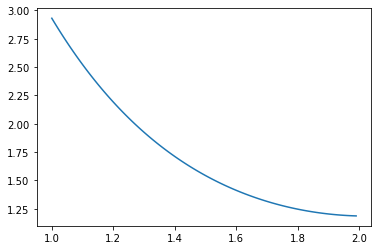

In [24]:
plt.plot(domains[0], waveFunctionProbabilities[0])

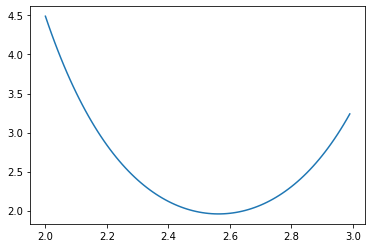

In [25]:
plt.plot(domains[1], waveFunctionProbabilities[1])

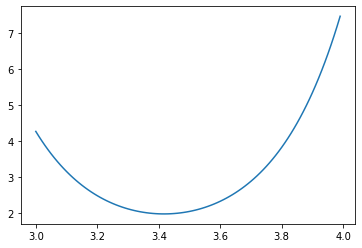

In [26]:
plt.plot(domains[2], waveFunctionProbabilities[2])

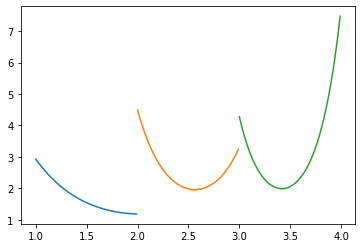

In [27]:
for ii in range(len(waveFunctionProbabilities)): 
    plt.plot(domains[ii], waveFunctionProbabilities[ii])

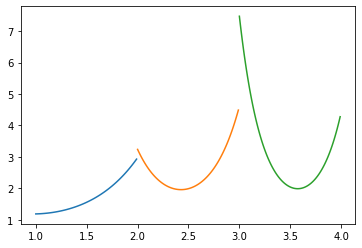

In [28]:
for ii in range(len(waveFunctionProbabilities)): 
    plt.plot(domains[ii], list(reversed(waveFunctionProbabilities[ii])))

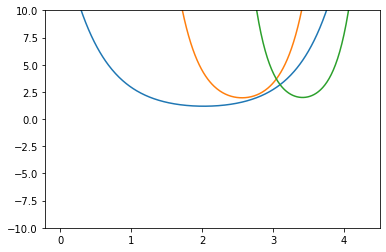

In [29]:
testDomain = np.arange(0, 4.3, resolution)
for ii in range(len(probabilityFunctions)): 
    plt.ylim([-10, 10])
    plt.plot(testDomain, probabilityFunctions[ii](testDomain))

In [30]:
waveFunctions = [
        generator["makeWaveFunction"](constants) \
        for generator in waveFunctionGenerators
    ]

In [31]:
probabilityAmplitudes = [
        waveFunctions[ii](domains[ii])
        for ii in range(len(waveFunctions))
    ]

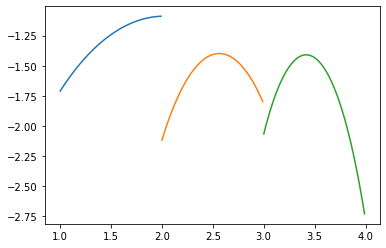

In [32]:
for ii in range(len(probabilityAmplitudes)): 
    plt.plot(domains[ii], 1j * probabilityAmplitudes[ii])

In [33]:
inspect.getsource(waveFunctions[0])

'        return lambda position_ : numericalWaveFunction(\n                **({positionIdentifier : position_} | arguments)\n            )\n'

In [34]:
probabilityAmplitudes[0]

array([0.+1.7114459j , 0.+1.69831972j, 0.+1.68536337j, 0.+1.67257556j,
       0.+1.659955j  , 0.+1.64750045j, 0.+1.63521064j, 0.+1.62308436j,
       0.+1.61112039j, 0.+1.59931753j, 0.+1.5876746j , 0.+1.57619044j,
       0.+1.5648639j , 0.+1.55369385j, 0.+1.54267918j, 0.+1.53181877j,
       0.+1.52111154j, 0.+1.51055643j, 0.+1.50015237j, 0.+1.48989833j,
       0.+1.47979328j, 0.+1.46983621j, 0.+1.46002612j, 0.+1.45036204j,
       0.+1.440843j  , 0.+1.43146804j, 0.+1.42223623j, 0.+1.41314665j,
       0.+1.40419838j, 0.+1.39539053j, 0.+1.38672222j, 0.+1.37819259j,
       0.+1.36980078j, 0.+1.36154594j, 0.+1.35342727j, 0.+1.34544393j,
       0.+1.33759515j, 0.+1.32988012j, 0.+1.32229808j, 0.+1.31484827j,
       0.+1.30752995j, 0.+1.30034239j, 0.+1.29328485j, 0.+1.28635665j,
       0.+1.27955709j, 0.+1.27288548j, 0.+1.26634116j, 0.+1.25992348j,
       0.+1.25363178j, 0.+1.24746546j, 0.+1.24142388j, 0.+1.23550645j,
       0.+1.22971256j, 0.+1.22404165j, 0.+1.21849314j, 0.+1.21306649j,
      

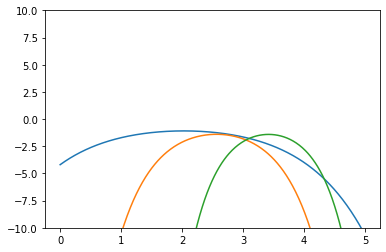

In [35]:
testDomain = np.arange(0, 5, resolution)
for ii in range(len(probabilityFunctions)): 
    plt.ylim([-10, 10])
    plt.plot(testDomain, waveFunctions[ii](testDomain) * 1j)

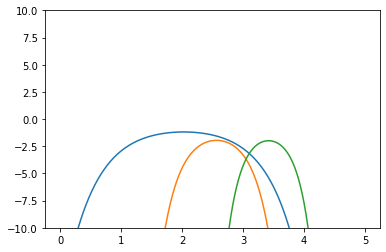

In [36]:
testDomain = np.arange(0, 5, resolution)
for ii in range(len(probabilityFunctions)): 
    plt.ylim([-10, 10])
    plt.plot(testDomain, waveFunctions[ii](testDomain) * 1j * waveFunctions[ii](testDomain) * -1j)